In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from tqdm import tqdm 
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchsummary import summary

# Подготовка тренировочного датасета

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

CUDA available: True
CUDA device name: NVIDIA GeForce RTX 2060
PyTorch CUDA version: 12.4
Tensor device: cuda:0


In [3]:
device

device(type='cuda')

In [4]:
pd.read_csv('../data/train_answers.csv').head()

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6


In [4]:
categories = pd.read_csv('../data/activity_categories.csv')

categories.head()

,id,category
0,0,sports
1,1,inactivity quiet/light
2,2,miscellaneous
3,3,occupation
4,4,water activities


In [5]:
id_to_category = dict(zip(categories['id'], categories['category']))

In [6]:
class HumanPoseDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        """
        img_dir: Папка с изображениями (img_train).
        csv_file: Путь к таблице с метками (например, 'train_answers.csv').
        transform: Трансформации для предобработки изображений.
        """
        self.img_dir = img_dir
        self.files = os.listdir(self.img_dir)
        self.labels = pd.read_csv(csv_file)  # Загружаем таблицу меток
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Достаем имя изображения и метку
        img_id = self.files[idx]
        img_id =img_id.split('.')[0]
        # img_id1 = self.labels.iloc[idx, 0]  # img_id (имя изображения)
        # label = self.labels.iloc[idx, 1]  # target_feature (метка)
        label = self.labels.loc[self.labels['img_id'] == int(img_id), 'target_feature'].values[0]

        # Загружаем изображение
        # img_path = os.path.join(self.img_dir, 'aug_'+str(img_id)+'.jpg')
        img_path = os.path.join(self.img_dir, str(img_id)+'.jpg')
        image = Image.open(img_path).convert("RGB")

        # Применяем трансформации
        if self.transform:
            image = self.transform(image)

        return image, label, img_id
    
    def __len__(self):
        return len(self.files)


# Создание папки с аугментированными изображениями и ответами к ним

Перед аугментацией, разобъем наш датасет на две части

In [9]:
#Класс для разделения
class SplitPFileToVal:
    def __init__(self, path_to_dir, path_to_new_dir_val, path_to_new_dir_train, p:float):
        """
        Создаёт 2 новые папки: Для валидации - % от всех изображений, для трейна - все остальное. 
        Нужно для отделения части датасета, для val данных

        path_to_dir: Папка с изображениями. (img_train)
        path_to_new_dir_val: Путь до новой папки, можно не создавать вручную.
        path_to_new_dir_train: Путь до новой папки, можно не создавать вручную.
        p: % изображений, которые будут отделены для валидационного датасета
        """

        #Проверка, введеного %
        if not isinstance(p, float):
            raise TypeError("% должен быть float")
        if p <= 0 or p > 1:
            raise ValueError("% должен быть в диапозоне: 0 < p <= 1")
        self.p = p

        self.path_to_dir = path_to_dir
        self.files = os.listdir(self.path_to_dir)
        self.path_to_new_dir_val = path_to_new_dir_val
        self.path_to_new_dir_train = path_to_new_dir_train



        # Создаем папки для сохранения
        if os.path.exists(path_to_new_dir_val):
            shutil.rmtree(path_to_new_dir_val)  # Удаляем папку, если она уже существует
        os.makedirs(path_to_new_dir_val, exist_ok=True)

        if os.path.exists(path_to_new_dir_train):
            shutil.rmtree(path_to_new_dir_train)  # Удаляем папку, если она уже существует
        os.makedirs(path_to_new_dir_train, exist_ok=True)

    def split(self):
        len_val = int(len(self.files)*self.p)
        len_train = len(self.files) - len_val
        with tqdm(total=len_val, desc="Отделение валидационных данных", unit="img") as pbar:
            for _ in range(len_val):
                idx = random.randint(0, len(self.files) - 1)
                file = self.files[idx]
                path_to_file = self.path_to_dir+f'/{file}'
                shutil.copy(path_to_file, self.path_to_new_dir_val+f'/{file}')
                self.files.pop(idx)

                pbar.update(1)

        with tqdm(total=len_train, desc="Отделение тренировочных данных", unit="img") as pbar:
            for _ in range(len_train):
                idx = random.randint(0, len(self.files) - 1)
                file = self.files[idx]
                path_to_file = self.path_to_dir+f'/{file}'
                shutil.copy(path_to_file, self.path_to_new_dir_train+f'/{file}')
                self.files.pop(idx)
                
                pbar.update(1)

        print(f"\nОтделено {len_val} изображений, для валидации в папку: {self.path_to_new_dir_val}")
        print(f"Отделено {len_train} изображений, для тренировки в папку: {self.path_to_new_dir_train}")



In [10]:
#Использование разделения
spliter = SplitPFileToVal(
    path_to_dir='../data/img_train',
    path_to_new_dir_val='../data/val_dataset',
    path_to_new_dir_train='../data/train_dataset',
    p=0.1
)

spliter.split()

Отделение тренировочных данных: 100%|██████████| 11131/11131 [00:34<00:00, 319.18img/s]


Отделено 1236 изображений, для валидации в папку: ../data/val_dataset
Отделено 11131 изображений, для тренировки в папку: ../data/train_dataset


In [11]:
#Класс для создания аугментаций
class AugmentedDatasetSaver:
    def __init__(self, original_train_dataset, csv_path, augmentation_transform, new_train_dataset_path, output_csv_path, augment_count):
        """
        Создает и сохраняет аугментированный датасет из тренировочного.
        Также создает csv с ответами на аугментированный датасет, сохраняет ответы из train_answers

        original_train_dataset: Исходный датасет (torch Dataset).
        csv_path: путь к csv с ответами
        augmentation_transform: Трансформации для аугментации.
        new_train_dataset_path: Папка, куда будут сохранены данные.
        output_csv_path: Путь, куда будет сохранена csv
        augment_count: Количество аугментированных изображений, которые нужно создать.
        """
        self.original_train_dataset_path = original_train_dataset
        self.augmentation_transform = augmentation_transform
        self.new_train_dataset_path = new_train_dataset_path
        self.output_csv_path = output_csv_path
        self.original_labels = pd.read_csv(csv_path)

        
        if augment_count >= len(original_train_dataset):
            print("Введеный augment_count > длины датасета")
        self.augment_count = augment_count


        # Создаем папку для сохранения
        if os.path.exists(new_train_dataset_path):
            shutil.rmtree(new_train_dataset_path)  # Удаляем папку, если она уже существует
        os.makedirs(new_train_dataset_path, exist_ok=True)

    def save(self):
        new_entries = []
        max_id = self.original_labels['img_id'].max()
        with tqdm(total=self.augment_count, desc="Создание аугментированных данных", unit="img") as pbar:
            for i in range(self.augment_count):
                # Выбираем случайное изображение из оригинального датасета
                image, label, img_id = random.choice(self.original_train_dataset_path)

                # Преобразуем в тензор, если это PIL.Image
                if not isinstance(image, Image.Image):
                    raise ValueError(f"Unsupported image format: {type(image)}")

                # Применяем аугментацию
                augmented_image = self.augmentation_transform(image)

                

                # Генерируем имя файла, сохраняя оригинальное имя с префиксом
                img_id = max_id+i+1

                new_entries.append({'img_id': int(img_id), 'target_feature': label})

                img_save_path = os.path.join(self.new_train_dataset_path, f"{img_id}.jpg")

                # Преобразуем аугментированный тензор обратно в PIL.Image и сохраняем
                augmented_image = transforms.ToPILImage()(augmented_image)  # Перевод тензора в PIL
                augmented_image.save(img_save_path)

                pbar.update(1)
        # Создание DataFrame для новых данных
        augmented_df = pd.DataFrame(new_entries)
        combined_df = pd.concat([self.original_labels, augmented_df], ignore_index=True)
        combined_df.to_csv(self.output_csv_path, index=False)
        
        print(f"CSV файл с метками успешно сохранён в: {self.output_csv_path}")
        print(f"\nСохранено {self.augment_count} аугментированных изображений в папке: {self.new_train_dataset_path}")


In [12]:
#transform для аугментации
augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=227, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=25), 
    transforms.ToTensor(),  # Преобразование в тензор для работы с RandomErasing
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3))
])

In [13]:
# Загружаем датасет, для тренировки
original_traint_dataset = HumanPoseDataset(
    img_dir='../data/train_dataset',
    csv_file='../data/train_answers.csv',
    transform=None  # Оставляем без изменений
)

# Папка для сохранения аугментированного датасета
save_dir = "../data/augmented_only_dataset"

# Количество аугментированных изображений
augment_count = 11000 

# Создаем и сохраняем 
dataset_saver = AugmentedDatasetSaver(
    original_train_dataset=original_traint_dataset,
    augmentation_transform=augmentation_transform,
    csv_path='../data/train_answers.csv',
    new_train_dataset_path=save_dir,
    augment_count=augment_count,
    output_csv_path='../data/augmented_train_answers.csv'
)

In [14]:
# Создание аугментированных файлов
dataset_saver.save()

Создание аугментированных данных: 100%|██████████| 11000/11000 [04:16<00:00, 42.96img/s]

CSV файл с метками успешно сохранён в: ../data/augmented_train_answers.csv

Сохранено 11000 аугментированных изображений в папке: ../data/augmented_only_dataset


Проверка, что все создалось в нужном кол-ве

In [15]:
line_count = sum(1 for line in open('../data/augmented_train_answers.csv')) - sum(1 for line in open('../data/train_answers.csv'))
if augment_count == line_count:
    print('OK')
else:
    print(f'Ожидалось {augment_count}(augment_count)\n Получилось {line_count}(line_count)')

OK


In [16]:
aug_file_count = len(os.listdir("../data/augmented_only_dataset"))
if augment_count == aug_file_count:
    print('OK')
else:
    print(f'Ожидалось {augment_count}(augment_count)\n Получилось {aug_file_count}(aug_file_count)')

OK


## Cоединение папки с аугментированными картинками и тренировочным датасетом в новую папку.

Удаляет папку по пути, который указан в path_augmented_only_dataset

In [17]:
def merge_folders(path_train_dataset, path_augmented_only_dataset, path_destination_folder):
    """
    Объединяет две папки с картинками в одну. УДАЛЯЕТ папку path_augmented_only_dataset

    :param path_train_dataset: Путь к первой исходной папке
    :param source_folder2: Путь ко второй исходной папке
    :param destination_folder: Путь к папке назначения
    """
    # Создаем папку назначения, если она не существует
    if os.path.exists(path_destination_folder):
        shutil.rmtree(path_destination_folder)  # Удаляем папку, если она уже существует
    os.makedirs(path_destination_folder, exist_ok=True)
    
    # Функция для копирования файлов из папки
    def copy_files_from_folder(folder):
        with tqdm(total=len(os.listdir(folder)), desc=f"Копирование из {folder}", unit="img") as pbar:
            for file_name in os.listdir(folder):
                source_path = os.path.join(folder, file_name)
                dest_path = os.path.join(path_destination_folder, file_name)
                
                # Проверяем, является ли элемент файлом
                if os.path.isfile(source_path):
                    if os.path.exists(dest_path):
                        raise KeyError('файл с таким именем уже существует в папке назначения')
                    shutil.copy2(source_path, dest_path)
                pbar.update(1)
    
    # Копируем файлы из обеих папок
    copy_files_from_folder(path_train_dataset)
    copy_files_from_folder(path_augmented_only_dataset)
    #Удаляем папку с аугментацией
    shutil.rmtree(path_augmented_only_dataset)

In [18]:
path_train_dataset = '../data/train_dataset'
path_augmented_only_dataset = "../data/augmented_only_dataset"
destination_folder = "../data/augmented_and_train_dataset"

In [19]:
merge_folders(path_train_dataset, path_augmented_only_dataset, destination_folder)

Копирование из ../data/augmented_only_dataset: 100%|██████████| 11000/11000 [00:02<00:00, 3990.32img/s]


In [20]:
expected_count = aug_file_count+len(os.listdir("../data/train_dataset"))
quantity_count = len(os.listdir("../data/augmented_and_train_dataset"))
if expected_count == quantity_count:
    print('OK')
else:
    print(f'Ожидалось {expected_count}(expected_count)\n Получилось {quantity_count}(quantity_count)')

OK


По итогу получилось:   
папка img_train -- картинки в оригинале,  
папка train_dataset -- часть датасета, для обучения,  
папка val_dataset -- часть датасета, для валидации,   
папка augmented_and_train_dataset -- augmented_only_dataset+img_train,   
augmented_train_answers.csv -- ответы на все папки  

# Начало работы с моделью

In [ ]:
# RANDOM_SEED = 52
# generator = torch.Generator().manual_seed(RANDOM_SEED)

In [8]:
print(f"Available CPU cores: {os.cpu_count()}")

Available CPU cores: 8


In [7]:
# transform_train = transforms.Compose([
#     transforms.Resize((227, 227)), # тк в ауг датасете есть фото без аугментации
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Изменяем размер изображений
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
val_dataset = HumanPoseDataset(
    img_dir='../data/val_dataset',
    csv_file='../data/train_answers.csv',
    transform=transform
)

train_dataset = HumanPoseDataset(
    img_dir='../data/augmented_and_train_dataset',
    csv_file='../data/augmented_train_answers.csv',
    transform=transform
)



# train_dataset, _ = random_split(dataset_train, [int(0.9*len(dataset_train)), len(dataset_train) - int(0.9*len(dataset_train))], generator)
# _, val_dataset = random_split(dataset_val, [int(0.9*len(dataset_val)), len(dataset_val) - int(0.9*len(dataset_val))], generator)

In [31]:
train_dataset[0]

(tensor([[[ 2.0434,  1.1872,  0.0398,  ...,  2.1804,  2.1462,  1.7694],
          [ 1.8893,  1.5639,  0.2967,  ...,  2.1462,  1.9920,  1.5639],
          [ 2.0263,  1.8893,  0.8276,  ...,  1.3755,  1.4269,  1.1015],
          ...,
          [ 1.2214,  1.2899,  1.3584,  ...,  0.5364,  0.4679,  0.4166],
          [ 1.2557,  1.3413,  1.3584,  ...,  0.5193,  0.4337,  0.3823],
          [ 1.2899,  1.3413,  1.3584,  ...,  0.5193,  0.4337,  0.3823]],
 
         [[ 0.6954,  0.1702, -0.5476,  ...,  2.3761,  2.3936,  2.1310],
          [ 0.5203,  0.4678, -0.3025,  ...,  2.3936,  2.3410,  2.0434],
          [ 0.6254,  0.6779,  0.0826,  ...,  1.6933,  1.8683,  1.6583],
          ...,
          [ 0.3978,  0.4678,  0.5028,  ...,  0.0651, -0.0399, -0.0924],
          [ 0.4328,  0.5028,  0.5378,  ...,  0.0126, -0.0749, -0.1275],
          [ 0.4678,  0.5203,  0.5553,  ...,  0.0126, -0.0749, -0.1275]],
 
         [[-0.3578, -0.5844, -0.6715,  ...,  2.6226,  2.6226,  2.5180],
          [-0.4798, -0.4101,

In [11]:
# Функция для отображения изображений с подписями
def show_images_with_labels(dataset, id_to_category, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        # Достаем изображение и метку
        image, label, img_id= dataset[i]
        # img_name = dataset.labels.iloc[i, 0]  # Имя файла

        # Декодируем метку в категорию
        category = id_to_category[label] if id_to_category else label

        # # Отображаем изображение
        axes[i].imshow(image.permute(1, 2, 0))  # Преобразуем тензор в (H, W, C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7351656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping in

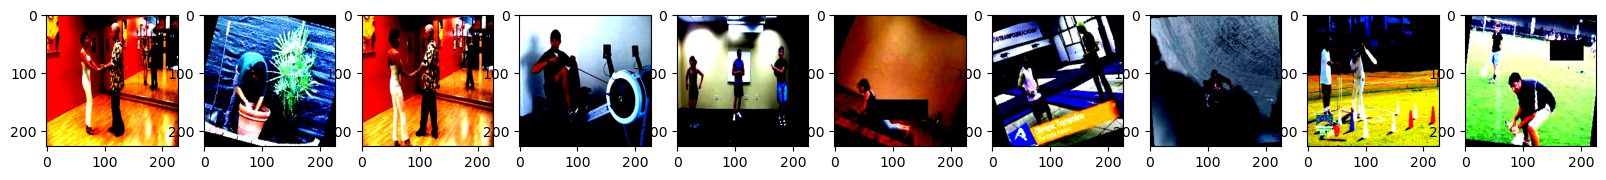

In [11]:
# Получить батч данных
# dataiter = iter(train_loader)
# images, labels = next(dataiter)

# Вывести первые 5 изображений в одну строку
show_images_with_labels(train_dataset, id_to_category, 10)

# Архитектуры

In [9]:
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(nn.functional.softplus(x))

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.mish = Mish()
        self.group_norm1 = nn.GroupNorm(32, out_channels)
        self.dropout1 = nn.Dropout2d(p=dropout_prob)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.group_norm2 = nn.GroupNorm(32, out_channels)
        self.dropout2 = nn.Dropout2d(p=dropout_prob)

        self.se_block = SEBlock(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.mish(out)
        out = self.group_norm1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.mish(out)
        out = self.group_norm2(out)
        out = self.dropout2(out)

        out = self.se_block(out)
        out += identity
        out = self.mish(out)
        return out

class UpdatedResNet(nn.Module):
    def __init__(self, block, layers, num_classes=20, dropout_prob=0.3):
        super(UpdatedResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.mish = Mish()
        self.group_norm = nn.GroupNorm(32, 64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_prob=0.3):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(32, out_channels)
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_prob=dropout_prob))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, dropout_prob=dropout_prob))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mish(x)
        x = self.group_norm(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def custom_resnet18(num_classes=20, dropout_prob=0.3):
    return UpdatedResNet(ResidualBlock, [2, 2, 2, 2], num_classes, dropout_prob)


In [9]:
import torch.nn.functional as F
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.fc(y)
        return x * y

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.2):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.mish = Mish()
        self.group_norm1 = nn.GroupNorm(32, out_channels)
        self.dropout1 = nn.Dropout2d(p=dropout_prob)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.group_norm2 = nn.GroupNorm(32, out_channels)
        self.dropout2 = nn.Dropout2d(p=dropout_prob)

        self.se_block = SEBlock(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.mish(out)
        out = self.group_norm1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.mish(out)
        out = self.group_norm2(out)
        out = self.dropout2(out)

        out = self.se_block(out)
        out += identity
        out = self.mish(out)
        return out

class UpdatedResNet(nn.Module):
    def __init__(self, block, layers, num_classes=20, dropout_prob=0.2):
        super(UpdatedResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.mish = Mish()
        self.group_norm = nn.GroupNorm(32, 64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_prob=0.2):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(32, out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_prob=dropout_prob))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, dropout_prob=dropout_prob))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mish(x)
        x = self.group_norm(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def custom_resnet18(num_classes=20, dropout_prob=0.2):
    return UpdatedResNet(ResidualBlock, [2, 2, 2, 2], num_classes, dropout_prob)

In [31]:
len(id_to_category)

20

In [ ]:
# summary(AlexNet(20).to(device), (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
              Mish-2         [-1, 64, 114, 114]               0
         GroupNorm-3         [-1, 64, 114, 114]             128
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]          36,864
              Mish-6           [-1, 64, 57, 57]               0
         GroupNorm-7           [-1, 64, 57, 57]             128
         Dropout2d-8           [-1, 64, 57, 57]               0
            Conv2d-9           [-1, 64, 57, 57]          36,864
             Mish-10           [-1, 64, 57, 57]               0
        GroupNorm-11           [-1, 64, 57, 57]             128
        Dropout2d-12           [-1, 64, 57, 57]               0
           Linear-13                    [-1, 4]             256
             ReLU-14                   

In [10]:
summary(custom_resnet18(dropout_prob=0.4).to(device), (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
              Mish-2         [-1, 64, 114, 114]               0
         GroupNorm-3         [-1, 64, 114, 114]             128
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]          36,864
              Mish-6           [-1, 64, 57, 57]               0
         GroupNorm-7           [-1, 64, 57, 57]             128
         Dropout2d-8           [-1, 64, 57, 57]               0
            Conv2d-9           [-1, 64, 57, 57]          36,864
             Mish-10           [-1, 64, 57, 57]               0
        GroupNorm-11           [-1, 64, 57, 57]             128
        Dropout2d-12           [-1, 64, 57, 57]               0
           Linear-13                    [-1, 4]             256
             ReLU-14                   

# Обучение

In [11]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from ignite.engine import Engine, Events
from ignite.handlers import Checkpoint, DiskSaver, global_step_from_engine
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar
import logging


/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [12]:
model = custom_resnet18(dropout_prob=0.5).to(device)

In [13]:
# Определение функции потерь и оптимизатора
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
weight_decay = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=weight_decay)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3)

In [14]:
import time

time.localtime()

time.struct_time(tm_year=2024, tm_mon=12, tm_mday=11, tm_hour=6, tm_min=59, tm_sec=31, tm_wday=2, tm_yday=346, tm_isdst=0)

In [15]:
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min',  # Или 'max', если метрика должна увеличиваться
#     factor=0.75,  # Во сколько раз уменьшать learning rate
#     patience=1,  # Сколько эпох ждать улучшений
#     verbose=True,  # Выводить сообщения о снижении learning rate
#     min_lr=1e-6  # Минимальное значение learning rate
# )

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [16]:
from ignite.handlers import EarlyStopping
# Определяем одну итерацию обучения (тренировочный шаг)
def train_step(engine, batch):
    model.train()  # Переводим модель в режим обучения
    images, labels, img_id = batch
    images, labels = images.to(device), labels.to(device)  # Перенос данных на устройство (CPU/GPU)
    optimizer.zero_grad()  # Обнуляем градиенты
    outputs = model(images)  # Прямой проход (forward pass)
    loss = criterion(outputs, labels)  # Вычисляем функцию потерь
    loss.backward()  # Вычисляем градиенты
    optimizer.step()  # Обновляем параметры модели
    # Возвращаем результаты: значение функции потерь, выходы модели и метки
    return {"loss": loss.item(), "outputs": outputs, "labels": labels}

# Определяем одну итерацию валидации
def val_step(engine, batch):
    model.eval()  # Переводим модель в режим оценки
    with torch.no_grad():  # Отключаем вычисление градиентов (ускоряет выполнение и экономит память)
        images, labels, img_id = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Прямой проход
        return outputs, labels  # Возвращаем предсказания и истинные метки

# Создаём движки (engines) для тренировки и валидации
trainer = Engine(train_step)  # Движок для обучения
evaluator = Engine(val_step)  # Движок для валидации

# Создаём обработчик ранней остановки
handler = EarlyStopping(
    patience=15,  # Количество эпох без улучшений
    score_function=lambda engine: -engine.state.metrics['loss'],  # Метрика для отслеживания
    # score_function=lambda engine: -engine.state.metrics['accuracy'],  # Метрика для отслеживания
    trainer=trainer, # Остановка тренировки
    min_delta=0.001
)

evaluator.add_event_handler(Events.COMPLETED, handler)

# Добавляем метрики для обучения
train_loss = Loss(criterion, output_transform=lambda x: (x["outputs"], x["labels"]))
train_accuracy = Accuracy(output_transform=lambda x: (x["outputs"], x["labels"]))
train_loss.attach(trainer, "loss")  # Привязываем метрику функции потерь к тренеру
train_accuracy.attach(trainer, "accuracy")  # Привязываем метрику точности к тренеру

# Добавляем метрики для валидации
Accuracy().attach(evaluator, "accuracy")  # Точность
Loss(criterion).attach(evaluator, "loss")  # Функция потерь

# Прогресс-бар для отображения статуса обучения
ProgressBar().attach(trainer)
ProgressBar().attach(evaluator)

cur_time = time.localtime()
path_suf = '_' + str(cur_time.tm_mday) + '_' + str(cur_time.tm_mon) + '_' + str(cur_time.tm_hour) + '_' + str(cur_time.tm_min)

# Настройка логирования
log_dir = "./train_info/logs" + path_suf
os.makedirs(log_dir, exist_ok=True)  # Создаём директорию для логов, если её нет
logging.basicConfig(
    filename="training.log",  # Файл для записи логов
    level=logging.INFO,  # Уровень логирования
    format="%(asctime)s - %(message)s",  # Формат записей
)
logger = logging.getLogger()  # Создаём логгер

# Создаём DataFrame для метрик
metrics_path = os.path.join(log_dir, "metrics.csv")
if os.path.exists(metrics_path):
    # Если файл уже существует, загружаем его (например, для продолжения тренировки)
    metrics_df = pd.read_csv(metrics_path)
else:
    # Создаём новый DataFrame, если файла ещё нет
    metrics_df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])

# Настраиваем сохранение модели при лучших результатах
to_save = {"model": model, "optimizer": optimizer, "trainer": trainer}
handler = Checkpoint(
    to_save,  # Что сохранять
    DiskSaver("./train_info/checkpoints" + path_suf, create_dir=True, require_empty=False, atomic=False),  # Диск-сохранитель
    n_saved=3,  # Сохранять только последние 3 чекпоинта
    filename_prefix="best",  # Префикс имени файла
    score_function=lambda engine: engine.state.metrics["accuracy"],  # Критерий выбора "лучшей" модели
    score_name="val_accuracy",  # Название критерия
    global_step_transform=global_step_from_engine(trainer),  # Глобальный шаг (номер итерации)
)

# Добавляем событие для логирования и сохранения метрик после каждой эпохи
@trainer.on(Events.EPOCH_COMPLETED)
def log_and_save_metrics(engine):
    # Получаем метрики для тренировки
    train_metrics = engine.state.metrics
    train_loss = train_metrics["loss"]
    train_accuracy = train_metrics["accuracy"]
    
    # Запускаем валидацию
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_accuracy = val_metrics["accuracy"]
    
    # Логируем метрики
    logger.info(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # Сохраняем метрики в DataFrame и записываем в CSV
    global metrics_df
    metrics_df = pd.concat(
        [metrics_df, pd.DataFrame({
            "Epoch": [engine.state.epoch],
            "Train Loss": [train_loss],
            "Train Accuracy": [train_accuracy],
            "Validation Loss": [val_loss],
            "Validation Accuracy": [val_accuracy],
        })],
        ignore_index=True
    )
    metrics_df.to_csv(metrics_path, index=False)  # Сохраняем таблицу в CSV
    
    # Сохраняем модель
    handler(evaluator)
    
    # Шаг для ReduceLROnPlateau
    lr_scheduler.step(val_loss)  # Здесь используем валидирующую функцию потерь как ключевую метрику


@trainer.on(Events.EPOCH_COMPLETED)
def log_lr_and_threshold(engine):
    current_lr = optimizer.param_groups[0]['lr']
    logger.info(f"Epoch {engine.state.epoch}: Learning Rate: {current_lr:.6f}, Weight Decay: {weight_decay:.4f}")
    print(f"Epoch {engine.state.epoch}: Learning Rate: {current_lr:.6f}, Weight Decay: {weight_decay:.4f}")


/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/ignite/handlers/tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Запуски с различными гиперпараметрами

In [17]:
# weight_decay = 
trainer.run(train_loader, max_epochs=50)

Epoch 1: Train Loss: 2.6374, Train Accuracy: 0.2007, Validation Loss: 2.5537, Validation Accuracy: 0.2144
Epoch 1: Learning Rate: 0.000848, Weight Decay: 0.0001


/tmp/ipykernel_208474/1840080456.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat(
/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
                                                     

Epoch 2: Train Loss: 2.5173, Train Accuracy: 0.2395, Validation Loss: 2.4719, Validation Accuracy: 0.2597
Epoch 2: Learning Rate: 0.000857, Weight Decay: 0.0001


Epoch 3: Train Loss: 2.4336, Train Accuracy: 0.2784, Validation Loss: 2.3572, Validation Accuracy: 0.3147
Epoch 3: Learning Rate: 0.000869, Weight Decay: 0.0001


Epoch 4: Train Loss: 2.3536, Train Accuracy: 0.3017, Validation Loss: 2.2708, Validation Accuracy: 0.3285
Epoch 4: Learning Rate: 0.000878, Weight Decay: 0.0001


Epoch 5: Train Loss: 2.2637, Train Accuracy: 0.3364, Validation Loss: 2.1846, Validation Accuracy: 0.3746
Epoch 5: Learning Rate: 0.000887, Weight Decay: 0.0001


Epoch 6: Train Loss: 2.2013, Train Accuracy: 0.3565, Validation Loss: 2.1681, Validation Accuracy: 0.3730
Epoch 6: Learning Rate: 0.000888, Weight Decay: 0.0001


Epoch 7: Train Loss: 2.1291, Train Accuracy: 0.3889, Validation Loss: 2.0814, Validation Accuracy: 0.4102
Epoch 7: Learning Rate: 0.000897, Weight Decay: 0.0001


Epoch 8: Train Loss: 2.0724, Train Accuracy: 0.4085, Validation Loss: 2.0350, Validation Accuracy: 0.4312
Epoch 8: Learning Rate: 0.000901, Weight Decay: 0.0001


Epoch 9: Train Loss: 1.9970, Train Accuracy: 0.4445, Validation Loss: 2.0382, Validation Accuracy: 0.4150
Epoch 9: Learning Rate: 0.000901, Weight Decay: 0.0001


Epoch 10: Train Loss: 1.9391, Train Accuracy: 0.4608, Validation Loss: 1.9236, Validation Accuracy: 0.4693
Epoch 10: Learning Rate: 0.000911, Weight Decay: 0.0001


Epoch 11: Train Loss: 1.8660, Train Accuracy: 0.4944, Validation Loss: 1.8482, Validation Accuracy: 0.5105
Epoch 11: Learning Rate: 0.000918, Weight Decay: 0.0001


Epoch 12: Train Loss: 1.7985, Train Accuracy: 0.5240, Validation Loss: 1.8553, Validation Accuracy: 0.5105
Epoch 12: Learning Rate: 0.000917, Weight Decay: 0.0001


Epoch 13: Train Loss: 1.7325, Train Accuracy: 0.5500, Validation Loss: 1.8083, Validation Accuracy: 0.5259
Epoch 13: Learning Rate: 0.000921, Weight Decay: 0.0001


Epoch 14: Train Loss: 1.6597, Train Accuracy: 0.5833, Validation Loss: 1.7514, Validation Accuracy: 0.5494
Epoch 14: Learning Rate: 0.000926, Weight Decay: 0.0001


Epoch 15: Train Loss: 1.5976, Train Accuracy: 0.6110, Validation Loss: 1.7047, Validation Accuracy: 0.5833
Epoch 15: Learning Rate: 0.000930, Weight Decay: 0.0001


Epoch 16: Train Loss: 1.5370, Train Accuracy: 0.6340, Validation Loss: 1.6805, Validation Accuracy: 0.5947
Epoch 16: Learning Rate: 0.000932, Weight Decay: 0.0001


Epoch 17: Train Loss: 1.4780, Train Accuracy: 0.6593, Validation Loss: 1.6885, Validation Accuracy: 0.5971
Epoch 17: Learning Rate: 0.000931, Weight Decay: 0.0001


Epoch 18: Train Loss: 1.4289, Train Accuracy: 0.6808, Validation Loss: 1.6402, Validation Accuracy: 0.6076
Epoch 18: Learning Rate: 0.000935, Weight Decay: 0.0001


Epoch 19: Train Loss: 1.3774, Train Accuracy: 0.7039, Validation Loss: 1.6756, Validation Accuracy: 0.6125
Epoch 19: Learning Rate: 0.000932, Weight Decay: 0.0001


Epoch 20: Train Loss: 1.3222, Train Accuracy: 0.7260, Validation Loss: 1.5833, Validation Accuracy: 0.6489
Epoch 20: Learning Rate: 0.000939, Weight Decay: 0.0001


Epoch 21: Train Loss: 1.2774, Train Accuracy: 0.7446, Validation Loss: 1.6066, Validation Accuracy: 0.6359
Epoch 21: Learning Rate: 0.000938, Weight Decay: 0.0001


Epoch 22: Train Loss: 1.2343, Train Accuracy: 0.7679, Validation Loss: 1.5819, Validation Accuracy: 0.6432
Epoch 22: Learning Rate: 0.000940, Weight Decay: 0.0001


Epoch 23: Train Loss: 1.1910, Train Accuracy: 0.7849, Validation Loss: 1.6213, Validation Accuracy: 0.6610
Epoch 23: Learning Rate: 0.000937, Weight Decay: 0.0001


Epoch 24: Train Loss: 1.1589, Train Accuracy: 0.7973, Validation Loss: 1.6145, Validation Accuracy: 0.6432
Epoch 24: Learning Rate: 0.000937, Weight Decay: 0.0001


Epoch 25: Train Loss: 1.1153, Train Accuracy: 0.8170, Validation Loss: 1.5821, Validation Accuracy: 0.6618
Epoch 25: Learning Rate: 0.000940, Weight Decay: 0.0001


Epoch 26: Train Loss: 1.0809, Train Accuracy: 0.8322, Validation Loss: 1.6159, Validation Accuracy: 0.6626
Epoch 26: Learning Rate: 0.000937, Weight Decay: 0.0001


Epoch 27: Train Loss: 1.0547, Train Accuracy: 0.8457, Validation Loss: 1.5813, Validation Accuracy: 0.6715
Epoch 27: Learning Rate: 0.000940, Weight Decay: 0.0001


Epoch 28: Train Loss: 1.0264, Train Accuracy: 0.8599, Validation Loss: 1.5538, Validation Accuracy: 0.6715
Epoch 28: Learning Rate: 0.000942, Weight Decay: 0.0001


Epoch 29: Train Loss: 0.9954, Train Accuracy: 0.8723, Validation Loss: 1.5980, Validation Accuracy: 0.6707
Epoch 29: Learning Rate: 0.000938, Weight Decay: 0.0001


Epoch 30: Train Loss: 0.9732, Train Accuracy: 0.8798, Validation Loss: 1.6146, Validation Accuracy: 0.6683
Epoch 30: Learning Rate: 0.000937, Weight Decay: 0.0001


Epoch 31: Train Loss: 0.9488, Train Accuracy: 0.8930, Validation Loss: 1.5944, Validation Accuracy: 0.6586
Epoch 31: Learning Rate: 0.000939, Weight Decay: 0.0001


Epoch 32: Train Loss: 0.9391, Train Accuracy: 0.8952, Validation Loss: 1.5839, Validation Accuracy: 0.6772
Epoch 32: Learning Rate: 0.000939, Weight Decay: 0.0001


Epoch 33: Train Loss: 0.9127, Train Accuracy: 0.9085, Validation Loss: 1.5520, Validation Accuracy: 0.6812
Epoch 33: Learning Rate: 0.000942, Weight Decay: 0.0001


Epoch 34: Train Loss: 0.9001, Train Accuracy: 0.9148, Validation Loss: 1.5660, Validation Accuracy: 0.6796
Epoch 34: Learning Rate: 0.000941, Weight Decay: 0.0001


Epoch 35: Train Loss: 0.8925, Train Accuracy: 0.9169, Validation Loss: 1.5669, Validation Accuracy: 0.6748
Epoch 35: Learning Rate: 0.000941, Weight Decay: 0.0001


Epoch 36: Train Loss: 0.8762, Train Accuracy: 0.9236, Validation Loss: 1.5584, Validation Accuracy: 0.6950
Epoch 36: Learning Rate: 0.000941, Weight Decay: 0.0001


Epoch 37: Train Loss: 0.8600, Train Accuracy: 0.9291, Validation Loss: 1.5366, Validation Accuracy: 0.6926
Epoch 37: Learning Rate: 0.000943, Weight Decay: 0.0001


Epoch 38: Train Loss: 0.8540, Train Accuracy: 0.9308, Validation Loss: 1.5691, Validation Accuracy: 0.6885
Epoch 38: Learning Rate: 0.000940, Weight Decay: 0.0001


Epoch 39: Train Loss: 0.8467, Train Accuracy: 0.9355, Validation Loss: 1.5530, Validation Accuracy: 0.6950
Epoch 39: Learning Rate: 0.000942, Weight Decay: 0.0001


Epoch 40: Train Loss: 0.8299, Train Accuracy: 0.9439, Validation Loss: 1.5326, Validation Accuracy: 0.6990
Epoch 40: Learning Rate: 0.000943, Weight Decay: 0.0001


Epoch 41: Train Loss: 0.8202, Train Accuracy: 0.9472, Validation Loss: 1.5957, Validation Accuracy: 0.6812
Epoch 41: Learning Rate: 0.000938, Weight Decay: 0.0001


Epoch 42: Train Loss: 0.8130, Train Accuracy: 0.9491, Validation Loss: 1.5534, Validation Accuracy: 0.6828
Epoch 42: Learning Rate: 0.000942, Weight Decay: 0.0001


Epoch 43: Train Loss: 0.8025, Train Accuracy: 0.9534, Validation Loss: 1.5670, Validation Accuracy: 0.6958
Epoch 43: Learning Rate: 0.000941, Weight Decay: 0.0001


Epoch 44: Train Loss: 0.8001, Train Accuracy: 0.9542, Validation Loss: 1.5439, Validation Accuracy: 0.6820
Epoch 44: Learning Rate: 0.000942, Weight Decay: 0.0001


Epoch 45: Train Loss: 0.7961, Train Accuracy: 0.9556, Validation Loss: 1.5785, Validation Accuracy: 0.6877
Epoch 45: Learning Rate: 0.000940, Weight Decay: 0.0001


Epoch 46: Train Loss: 0.7843, Train Accuracy: 0.9605, Validation Loss: 1.5795, Validation Accuracy: 0.6699
Epoch 46: Learning Rate: 0.000940, Weight Decay: 0.0001


Epoch 47: Train Loss: 0.7776, Train Accuracy: 0.9633, Validation Loss: 1.5583, Validation Accuracy: 0.6812
Epoch 47: Learning Rate: 0.000941, Weight Decay: 0.0001


Epoch 48: Train Loss: 0.7752, Train Accuracy: 0.9615, Validation Loss: 1.5720, Validation Accuracy: 0.6845
Epoch 48: Learning Rate: 0.000940, Weight Decay: 0.0001


Epoch 49: Train Loss: 0.7685, Train Accuracy: 0.9639, Validation Loss: 1.5854, Validation Accuracy: 0.6804
Epoch 49: Learning Rate: 0.000939, Weight Decay: 0.0001


Epoch 50: Train Loss: 0.7648, Train Accuracy: 0.9643, Validation Loss: 1.5568, Validation Accuracy: 0.6934
Epoch 50: Learning Rate: 0.000941, Weight Decay: 0.0001


State:
	iteration: 17300
	epoch: 50
	epoch_length: 346
	max_epochs: 50
	output: <class 'dict'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [19]:
# weight_decay = 1e-4
trainer.run(train_loader, max_epochs=50)

# Полный output обучения можно посмотреть в traning.log

Epoch 1: Train Loss: 0.7504, Train Accuracy: 0.9674, Validation Loss: 1.5432, Validation Accuracy: 0.6853
Epoch 1: Learning Rate: 0.000942, Weight Decay: 0.0001


Epoch 2: Train Loss: 0.7515, Train Accuracy: 0.9657, Validation Loss: 1.5350, Validation Accuracy: 0.6837
Epoch 2: Learning Rate: 0.000943, Weight Decay: 0.0001


Epoch 3: Train Loss: 0.7380, Train Accuracy: 0.9713, Validation Loss: 1.5524, Validation Accuracy: 0.6893
Epoch 3: Learning Rate: 0.000942, Weight Decay: 0.0001


Epoch 4: Train Loss: 0.7396, Train Accuracy: 0.9692, Validation Loss: 1.5725, Validation Accuracy: 0.6804
Epoch 4: Learning Rate: 0.000940, Weight Decay: 0.0001


Epoch 5: Train Loss: 0.7355, Train Accuracy: 0.9706, Validation Loss: 1.5433, Validation Accuracy: 0.6861
Epoch 5: Learning Rate: 0.000942, Weight Decay: 0.0001


Epoch 6: Train Loss: 0.7410, Train Accuracy: 0.9680, Validation Loss: 1.5536, Validation Accuracy: 0.6772
Epoch 6: Learning Rate: 0.000942, Weight Decay: 0.0001


Epoch 7: Train Loss: 0.7273, Train Accuracy: 0.9732, Validation Loss: 1.5532, Validation Accuracy: 0.6804
Epoch 7: Learning Rate: 0.000942, Weight Decay: 0.0001


Epoch 8: Train Loss: 0.7244, Train Accuracy: 0.9741, Validation Loss: 1.5424, Validation Accuracy: 0.6804
Epoch 8: Learning Rate: 0.000942, Weight Decay: 0.0001


2024-12-11 06:43:47,893 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 9: Train Loss: 0.7279, Train Accuracy: 0.9727, Validation Loss: 1.5696, Validation Accuracy: 0.6926
Epoch 9: Learning Rate: 0.000940, Weight Decay: 0.0001


State:
	iteration: 3114
	epoch: 9
	epoch_length: 346
	max_epochs: 50
	output: <class 'dict'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [26]:
trainer.run(train_loader, max_epochs=50)

2024-12-11 01:20:49,081 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 24: Train Loss: 0.0935, Train Accuracy: 0.9746, Validation Loss: 1.4203, Validation Accuracy: 0.6764
Epoch 24: Learning Rate: 0.000016, Weight Decay: 0.0001


State:
	iteration: 8304
	epoch: 24
	epoch_length: 346
	max_epochs: 50
	output: <class 'dict'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

# Просмотр результатов обучения

In [25]:
trainer.run(train_loader, max_epochs=50)

Epoch [26/50]: [19/277]   7%|▋          [00:03<00:58]

KeyboardInterrupt: 

Перед просмотром результатов обучения, убедитесь, что запускали ячеки из папок 'Подготовка тренировочного датасета' и 'Архитектуры'

In [26]:
import pandas as pd
from torch.optim import Adam
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine

In [ ]:
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3)

<Axes: >

<Figure size 640x480 with 0 Axes>

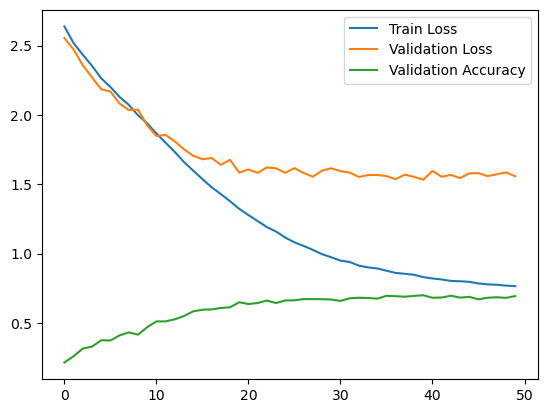

In [18]:
metrics_path = "./train_info/logs_11_12_7_1_custom_resnet18_dp=05/metrics.csv"

metrics = pd.read_csv(metrics_path)

plt.figure()
metrics[['Train Loss', 'Validation Loss', 'Validation Accuracy']].plot()

In [22]:
from ignite.handlers import Checkpoint
import torch

In [23]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

CUDA available: True
CUDA device name: NVIDIA GeForce RTX 4070 SUPER
PyTorch CUDA version: 12.4
Tensor device: cuda:0


In [ ]:
model = AlexNet(20).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [25]:
checkpoint_path = "./train_info/checkpoints_5_12_20_59/best_checkpoint_95_val_accuracy=0.5004.pt"

checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

model.eval()

start_epoch = checkpoint["trainer"]['iteration'] / checkpoint["trainer"]['epoch_length']
start_epoch

C:\Users\Vlad\AppData\Local\Temp\ipykernel_8468\910594076.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


95.0

In [26]:
checkpoint['trainer']

OrderedDict([('epoch_length', 174), ('max_epochs', 100), ('iteration', 16530)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


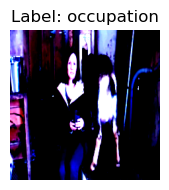

occupation


In [27]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

show_images_row([images[0]], [label.item() for label in labels[:5]], size=(2, 2))

probabilities = torch.softmax(model(images[0].unsqueeze(0).to(device)), dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

print(id_to_category[predicted_class])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


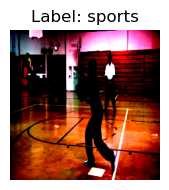

sports


In [30]:
dataiter = iter(DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=0))
images, labels = next(dataiter)

show_images_row([images[0]], [label.item() for label in labels[:5]], size=(2, 2))

probabilities = torch.softmax(model(images[0].unsqueeze(0).to(device)), dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

print(id_to_category[predicted_class])

In [29]:
from ignite.metrics import Accuracy
from ignite.metrics import Precision, Recall, Fbeta, Accuracy

# Функция инференса для вычисления метрик
def inference_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        return outputs, labels

# Создаём Engine для инференса
evaluator = Engine(inference_step)

# Добавляем метрику Accuracy
accuracy = Accuracy()
precision = Precision(average=True)
recall = Recall(average=True)
f1 = Fbeta(beta=1.0, average=True)

accuracy.attach(evaluator, "accuracy")
precision.attach(evaluator, "precision")
recall.attach(evaluator, "recall")
f1.attach(evaluator, "f1")

pbar = ProgressBar(persist=True)
pbar.attach(evaluator)

# Оценка на валидационном датасете
state = evaluator.run(val_loader)

print(f"Validation Accuracy: {state.metrics['accuracy']:.4f}")
print(f"Validation Precision: {state.metrics['precision']:.4f}")
print(f"Validation Recall: {state.metrics['recall']:.4f}")
print(f"Validation F1 Score: {state.metrics['f1']:.4f}")

c:\Users\Vlad\.conda\envs\DL_ENV\lib\site-packages\ignite\handlers\tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Iteration: [20/20] 100%|██████████ [00:16<00:00]

Validation Accuracy: 0.5004
Validation Precision: 0.3904
Validation Recall: 0.3489
Validation F1 Score: 0.3578
